# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = False
data["outcome"][data["loan_status"]=="Default"]=True
data["outcome"][data["loan_status"]=="Charged Off"]=True

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], len(data), p=[0.7, 0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [10]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [11]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred, 'Accuracy': accuracy_score(y_test, y_pred), 'Brier': brier_score}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [12]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Naive Bayes Classifier
Fit time: 0.37 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



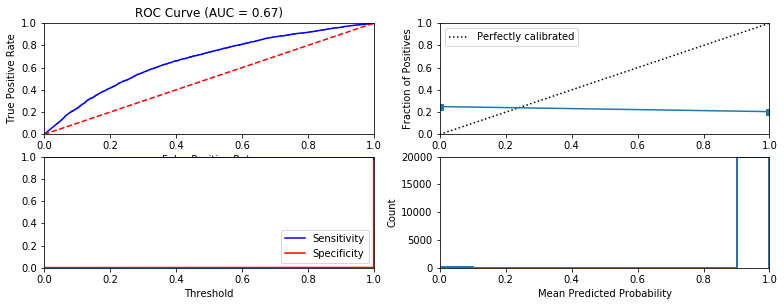


Similarity to LC grade ranking:  0.6766719497249758
Brier score: 0.793590552002484
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.22053333]


In [13]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name="Naive Bayes Classifier")

### $l_1$ regularized logistic regression

  Model: L1 regularized logistic regression
Fit time: 36.4 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.5102497739039465
Accuracy:  0.79525
              precision    recall  f1-score   support

  No default     0.7987    0.9926    0.8852     15904
     Default     0.5021    0.0288    0.0545      4096

   micro avg     0.7953    0.7953    0.7953     20000
   macro avg     0.6504    0.5107    0.4698     20000
weighted avg     0.7380    0.7953    0.7151     20000



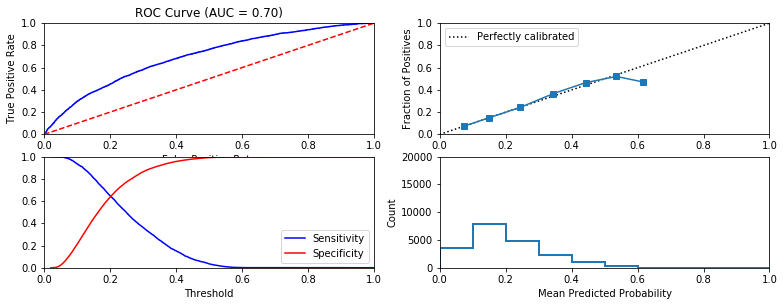


Similarity to LC grade ranking:  0.6917245761743395
Brier score: 0.14957318141360365
Were parameters on edge? : False
Score variations around CV search grid : 0.016668055671317985
[0.79986667 0.79986667 0.79993333 0.79983333 0.7998    ]


In [14]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'L1 regularized logistic regression')

### $l_2$ regularized logistic regression

  Model: L2 regularized logistic regression
Fit time: 2.86 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.5058543728978377
Accuracy:  0.7954
              precision    recall  f1-score   support

  No default     0.7996    0.9911    0.8851     15904
     Default     0.5070    0.0354    0.0662      4096

   micro avg     0.7954    0.7954    0.7954     20000
   macro avg     0.6533    0.5133    0.4756     20000
weighted avg     0.7397    0.7954    0.7174     20000



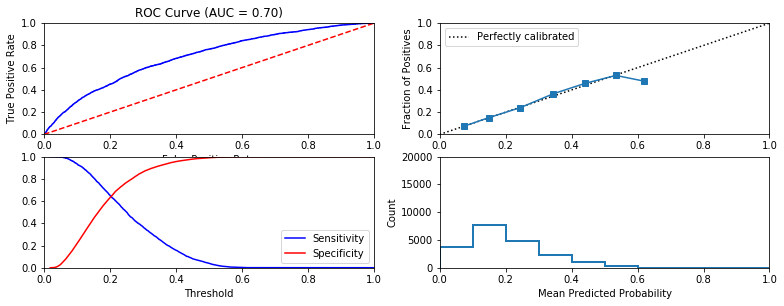


Similarity to LC grade ranking:  0.6943152647520213
Brier score: 0.14943953716504435
Were parameters on edge? : False
Score variations around CV search grid : 0.05415087266214812
[0.79986667 0.79993333 0.80023333 0.79996667 0.7998    ]


In [15]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'L2 regularized logistic regression')

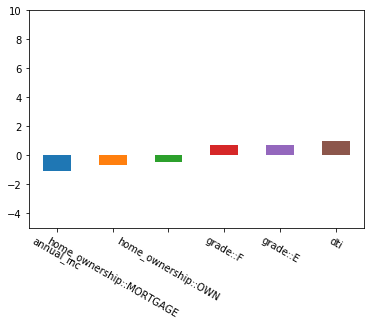

In [16]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision tree
Fit time: 5.03 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 4}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



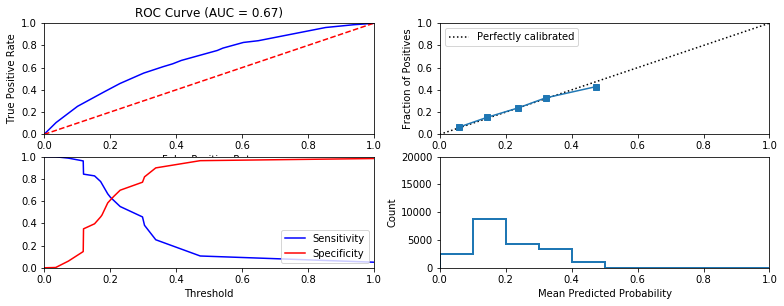


Similarity to LC grade ranking:  0.7243212567484273
Brier score: 0.15314423417449807
Were parameters on edge? : True
Score variations around CV search grid : 2.3485733355581564
[0.79843333 0.79546667 0.79176667 0.78683333 0.7803     0.79906667
 0.79843333 0.79526667 0.7929     0.78763333]


In [17]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision tree')

### Random forest

  Model: Random forest
Fit time: 667.51 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.3850274843390068
Accuracy:  0.7931
              precision    recall  f1-score   support

  No default     0.8096    0.9674    0.8815     15904
     Default     0.4789    0.1165    0.1874      4096

   micro avg     0.7931    0.7931    0.7931     20000
   macro avg     0.6442    0.5419    0.5344     20000
weighted avg     0.7418    0.7931    0.7393     20000



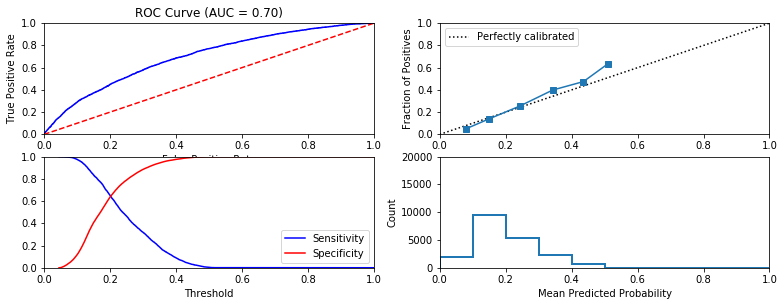


Similarity to LC grade ranking:  0.7381550940855796
Brier score: 0.15018348238667764
Were parameters on edge? : True
Score variations around CV search grid : 0.0749625187406353
[0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.80003333 0.7999     0.7999     0.79986667 0.79986667
 0.8004     0.80016667 0.80026667 0.80006667 0.7999     0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.7999     0.7999     0.7998     0.79983333 0.79986667 0.79986667
 0.8        0.79986667 0.80016667 0.80006667 0.79986667 0.79986667]


In [19]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random forest')

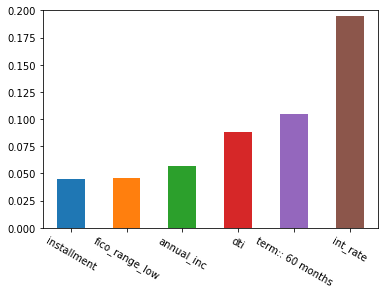

In [20]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer perceptron
Fit time: 2459.44 seconds
Optimal parameters:
{'alpha': 0.01, 'hidden_layer_sizes': 5, 'max_iter': 500, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4990437177304169
Accuracy:  0.7932
              precision    recall  f1-score   support

  No default     0.8023    0.9820    0.8831     15904
     Default     0.4625    0.0603    0.1067      4096

   micro avg     0.7932    0.7932    0.7932     20000
   macro avg     0.6324    0.5211    0.4949     20000
weighted avg     0.7327    0.7932    0.7241     20000



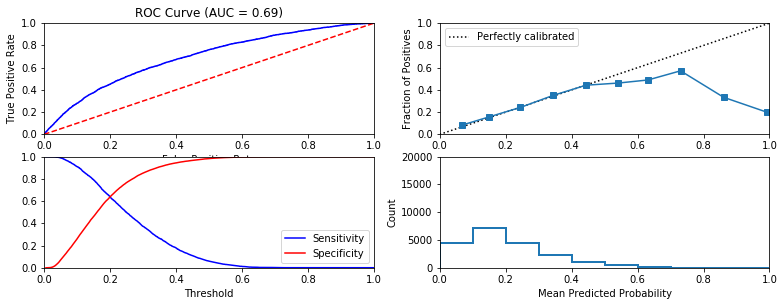


Similarity to LC grade ranking:  0.6509952170711207
Brier score: 0.1508397366725284
Were parameters on edge? : True
Score variations around CV search grid : 0.947017104714233
[0.79576667 0.79816667 0.7958     0.7962     0.79613333 0.79693333
 0.79726667 0.79553333 0.79646667 0.79656667 0.79583333 0.79523333
 0.7962     0.79333333 0.79643333 0.79233333 0.79213333 0.79373333
 0.79333333 0.7932     0.79476667 0.799      0.79863333 0.79816667
 0.7954     0.7978     0.79603333 0.79596667 0.7961     0.79646667
 0.7944     0.79636667 0.79636667 0.79496667 0.7956     0.79586667
 0.79466667 0.79596667 0.79443333 0.7928     0.79453333 0.7923
 0.7975     0.79803333 0.79643333 0.7966     0.7966     0.7963
 0.7965     0.79836667 0.79746667 0.79546667 0.7972     0.79706667
 0.7955     0.7953     0.7937     0.79226667 0.79466667 0.79426667
 0.79303333 0.79296667 0.7931     0.79703333 0.79703333 0.7981
 0.79773333 0.79783333 0.7961     0.7948     0.7972     0.79643333
 0.7939     0.79463333 0.7941   

In [21]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'solver': ['lbfgs'], 
                 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12)}

mlp = fit_classification(mlp, data_dict, cv_parameters, 'Multi-layer perceptron')

## Train and Test logistic regression model with features derived by LendingClub

  Model: l1-regularized with lendingClub-defined feature
Fit time: 0.52 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



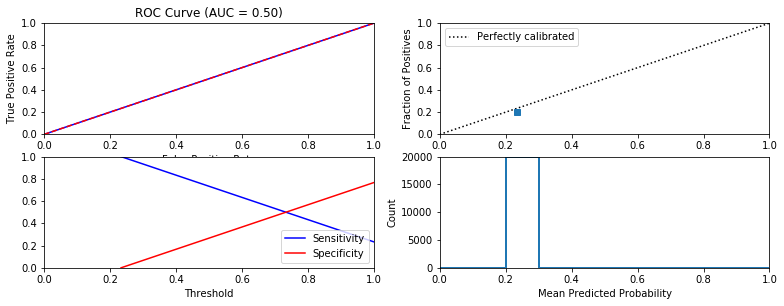


Similarity to LC grade ranking:  nan
Brier score: 0.1636787753317082
Were parameters on edge? : True
Score variations around CV search grid : 0.34172362060342404
[0.79986667 0.79986667 0.7976     0.7973     0.79713333]


In [22]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'int_rate'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}
lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters, 'l1-regularized with lendingClub-defined feature')

  Model: l2-regularized with lendingClub-defined feature
Fit time: 0.38 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



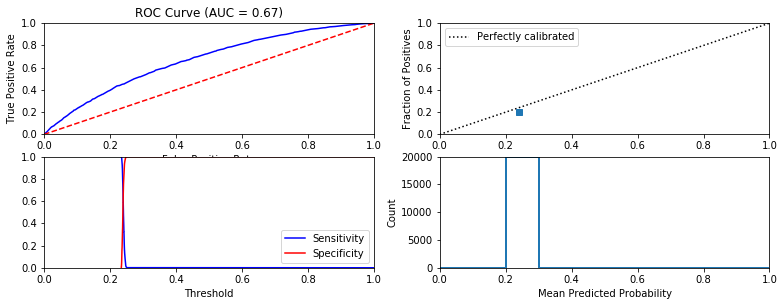


Similarity to LC grade ranking:  0.8551684780693735
Brier score: 0.163521704251794
Were parameters on edge? : True
Score variations around CV search grid : 0.34589098183029476
[0.79986667 0.79986667 0.7978     0.7971     0.79713333]


In [23]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters, 'l2-regularized with lendingClub-defined feature')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [24]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict_100 = []
for i in range(100):
    data_dict = prepare_data(feature_subset = your_features,random_state = i)
    data_dict_100.append(data_dict)

In [25]:
def fit_100(model,cv_parameters = {},model_name=None):    
    accuracy_score = []
    brier_score = []
    for i in range(100):
        m = model
        m = fit_classification(m,data_dict_100[i],
                          cv_parameters = cv_parameters,
                          model_name = model_name,
                          print_to_screen = False)
        accuracy_score.append(m['Accuracy'])
        brier_score.append(m['Brier'])
    print('Model:'+model_name)
    print('Accuracy: ('+ str(np.mean(accuracy_score)) + ', ' + str(np.std(accuracy_score)) + ')')
    print('Brier: ('+ str(np.mean(brier_score)) + ', ' + str(np.std(brier_score)) + ')')
    return m

In [26]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_100(gnb,model_name="Naive Bayes Classifier")

Model:Naive Bayes Classifier
Accuracy: (0.7964245000000001, 0.002742339284260797)
Brier: (0.7125112075509402, 0.16182247095761576)


In [27]:
## Train and test a l_1 regularized logistic regression classifier

l1_afterRemoving_logistic = LogisticRegression(penalty='l1', n_jobs=-1)
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}

l1_afterRemoving_logistic = fit_100(l1_afterRemoving_logistic, cv_parameters, 'L1 regularized logistic regression')

Model:L1 regularized logistic regression
Accuracy: (0.7968189999999999, 0.0027574062087403826)
Brier: (0.15319957500635517, 0.005151907928456971)


In [28]:
## Train and test a l_2 regularized logistic regression classifier

l2_afterRemoving_logistic = LogisticRegression(penalty='l2', n_jobs=-1)
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}

l2_afterRemoving_logistic = fit_100(l2_afterRemoving_logistic, cv_parameters, 'L2 regularized logistic regression')

Model:L2 regularized logistic regression
Accuracy: (0.796843, 0.0027616029765337364)
Brier: (0.15185704187052526, 0.0026681934295391687)


In [29]:
## Train and test a decision tree classifier

decision_tree_afterRemoving = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}

decision_tree_afterRemoving = fit_100(decision_tree_afterRemoving, cv_parameters, 'Decision tree')

Model:Decision tree
Accuracy: (0.7963355000000001, 0.002738679380650458)
Brier: (0.15396202504461953, 0.001621537585556248)


In [31]:
## Train and test a random forest classifier

random_forest_afterRemoving = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'n_estimators': [200, 500],
                'max_depth' : [4,5,6,7,8],
                }

random_forest_afterRemoving = fit_100(random_forest_afterRemoving, cv_parameters, 'Random forest')

Model:Random forest
Accuracy: (0.7945249999999998, 0.0033988932022056815)
Brier: (0.153077494795604, 0.0021029253069316228)


In [52]:
## Train and test a multi-layer perceptron classifier

mlp_afterRemoving = MLPClassifier()
cv_parameters = {'solver': ['lbfgs'], 
                 'alpha': 10.0 ** -np.arange(1, 4), 
                 'hidden_layer_sizes':np.arange(5, 10)}

mlp_afterRemoving = fit_100(mlp_afterRemoving, cv_parameters, 'Multi-layer perceptron')

Model:Multi-layer perceptron
Accuracy: (0.7960445000000002, 0.0028901028960921136)
Brier: (0.15176258307758878, 0.0015557607872835654)


## Time stability test of YOURMODEL

  Model: Random Forest trained on 2010 model
Fit time: 27.38 seconds
Optimal parameters:
{'max_depth': 4, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.18976578990290016
Accuracy:  0.8471428571428572
              precision    recall  f1-score   support

  No default     0.8739    0.9642    0.9168      6117
     Default     0.1275    0.0362    0.0564       883

   micro avg     0.8471    0.8471    0.8471      7000
   macro avg     0.5007    0.5002    0.4866      7000
weighted avg     0.7798    0.8471    0.8083      7000



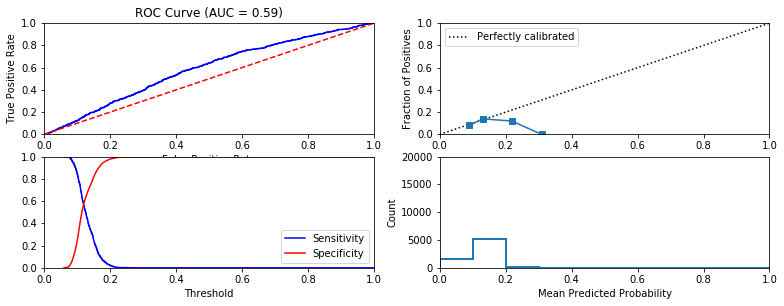


Similarity to LC grade ranking:  0.4209565429251944
Brier score: 0.10953067815512123
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.87677371 0.87677371 0.87677371 0.87677371 0.87677371 0.87677371
 0.87677371 0.87677371 0.87677371 0.87677371]
  Model: Random Forest trained on 2016 model
Fit time: 46.37 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.3186316118176936
Accuracy:  0.8017142857142857
              precision    recall  f1-score   support

  No default     0.8838    0.8888    0.8863      6087
     Default     0.2298    0.2212    0.2254       913

   micro avg     0.8017    0.8017    0.8017      7000
   macro avg     0.5568    0.5550    0.5559      7000
weighted avg     0.7985    0.8017    0.8001      7000



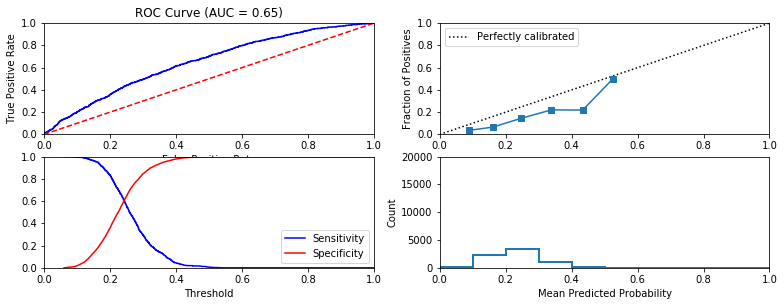


Similarity to LC grade ranking:  0.3910498232950896
Brier score: 0.12116367921743407
Were parameters on edge? : True
Score variations around CV search grid : 0.10253405595429757
[0.75777778 0.75777778 0.75777778 0.75777778 0.75777778 0.75777778
 0.758      0.75788889 0.75855556 0.758     ]


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=8, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([False,  True, False, ..., False, False, False]),
 'Accuracy': 0.8017142857142857,
 'Brier': 0.12116367921743407,
 'y_pred_probs': array([0.29527283, 0.33129064, 0.16670671, ..., 0.16689973, 0.19387076,
        0.2433482 ])}

In [35]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
YOURMODEL = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'n_estimators': [200, 500],
                'max_depth' : [4,5,6,7,8],
                }

fit_classification(YOURMODEL, data_dict_test, cv_parameters, 'Random Forest trained on 2010 model')


start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)


data_dict_test_2016 = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)



fit_classification(YOURMODEL, data_dict_test_2016, cv_parameters, 'Random Forest trained on 2016 model')


## Train and test YOURMODEL on the original data

  Model: Random Forest trained on original data
Fit time: 146.83 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.3726178249231807
Accuracy:  0.7911
              precision    recall  f1-score   support

  No default     0.8116    0.9601    0.8797     15904
     Default     0.4654    0.1348    0.2090      4096

   micro avg     0.7911    0.7911    0.7911     20000
   macro avg     0.6385    0.5475    0.5443     20000
weighted avg     0.7407    0.7911    0.7423     20000



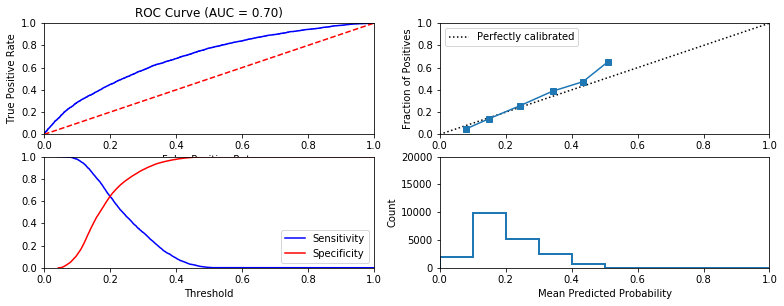


Similarity to LC grade ranking:  0.740644267024652
Brier score: 0.15026592212383297
Were parameters on edge? : True
Score variations around CV search grid : 0.041656252603525075
[0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.7999     0.79986667 0.8002     0.80016667]


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=8, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'Accuracy': 0.7911,
 'Brier': 0.15026592212383297,
 'y_pred_probs': array([0.36956053, 0.16209605, 0.19557912, ..., 0.12449409, 0.10126112,
        0.230714  ])}

In [36]:
YOURMODEL = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'n_estimators': [200, 500],
                'max_depth' : [4,5,6,7,8],
               }
data_dict = prepare_data()
fit_classification(YOURMODEL, data_dict, cv_parameters, 'Random Forest trained on original data')


## Test regression models

In [37]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [38]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
data_dict = prepare_data(feature_subset = your_features)
reg_lasso = linear_model.Lasso()
reg_lasso = fit_regression(reg_lasso, data_dict, cv_parameters, model_name="L1 regularized linear regression")

  Model: L1 regularized linear regression  Return column: ret_PESS
Fit time: 0.79 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.015295522420940122
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -12.820352458585218
All test scores : [-0.09763992 -0.1101577  -0.1101577  -0.1101577  -0.1101577 ]
  Model: L1 regularized linear regression  Return column: ret_OPT
Fit time: 0.73 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.007510609646451005
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -26.663790043364028
All test scores : [-0.02577147 -0.03264311 -0.03264311 -0.03264311 -0.03264311]
  Model: L1 regularized linear regression  Return column: ret_INTa
Fit time: 0.73 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.015487248944106136
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -11.012606075331108
All test scores 

In [39]:
reg_lasso_separate = linear_model.Lasso()

reg_lasso_separate = fit_regression(reg_lasso_separate, data_dict, cv_parameters, model_name="L1 regularized linear regression", separate=True)

  Model: L1 regularized linear regression  Return column: ret_PESS
Fit time: 0.53 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.004018186587105843
model_1: 0.08568113602026739
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -2.300963751547581
All test scores : [-0.17805226 -0.18214917 -0.18214917 -0.18214917 -0.18214917]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -110.97029480740997
All test scores : [-0.10272087 -0.18304062 -0.21671051 -0.21671051 -0.21671051]
  Model: L1 regularized linear regression  Return column: ret_OPT
Fit time: 0.46 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.09338895622988475
model_1: 0.07882663766027032
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 112.0708188168722
All test scores : [ 0.0897332

### $l_2$ regularized linear regressor

In [40]:
## trying l2 regularized linear regression with hyper-parameters
cv_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
reg_ridge = linear_model.Ridge()
reg_ridge = fit_regression(reg_ridge, data_dict, cv_parameters, model_name="L2 regularized linear regression")

  Model: L2 regularized linear regression  Return column: ret_PESS
Fit time: 0.56 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.030769724085067507
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.7596726467764628
All test scores : [-0.08249865 -0.08247703 -0.08232991 -0.08200015 -0.08187666]
  Model: L2 regularized linear regression  Return column: ret_OPT
Fit time: 0.67 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.014428665010733255
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.3482116013933276
All test scores : [-0.02472082 -0.02471172 -0.02464503 -0.02447414 -0.02439197]
  Model: L2 regularized linear regression  Return column: ret_INTa
Fit time: 0.67 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.03483552420104008
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.131617613921133
All test scores : [-0.07501

In [41]:
reg_ridge_separate = linear_model.Ridge()
reg_ridge_separate = fit_regression(reg_ridge_separate, data_dict, cv_parameters, model_name="L2 regularized linear regression", separate=True)

  Model: L2 regularized linear regression  Return column: ret_PESS
Fit time: 0.57 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 1}

Testing r2 scores:
model_0: 0.03012751471709274
model_1: 0.091964133992809
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -1.7604803550907715
All test scores : [-0.14959627 -0.14949387 -0.14880189 -0.14743304 -0.14700822]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -2.1598240142834153
All test scores : [-0.08661114 -0.0856656  -0.08504989 -0.08478004 -0.08493509]
  Model: L2 regularized linear regression  Return column: ret_OPT
Fit time: 0.47 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.1053174089353861
model_1: 0.08684200027132771
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 1.1958367748527488
All test scores : [0.10100132 0.10106294 0.

### Multi-layer perceptron regressor

In [53]:
## trying multi-layer perceptron regression with hyper-parameters
reg_mlp = MLPRegressor()
cv_parameters = { 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12),
                'activation': ["logistic", "relu", "tanh"]
                }

reg_mlp = fit_regression(reg_mlp, data_dict, cv_parameters, model_name = 'Multi-layer peceptron regressor')

  Model: Multi-layer peceptron regressor  Return column: ret_PESS
Fit time: 1274.15 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'max_iter': 1500}

Testing r2 score: 0.011958724891205308
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -339.02112514894344
All test scores : [-0.11531067 -0.10389493 -0.13000635 -0.09140932 -0.07791391 -0.12961912
 -0.08021501 -0.08848064 -0.10520377 -0.10853537 -0.08227254 -0.112785
 -0.0642927  -0.08834546 -0.07454674 -0.06018454 -0.07144125 -0.11843969
 -0.07844656 -0.07147805 -0.12815238 -0.09802139 -0.15659356 -0.11607984
 -0.10313838 -0.09181548 -0.08606701 -0.09056    -0.07778175 -0.10987931
 -0.07173474 -0.07761169 -0.07096962 -0.07845996 -0.07937345 -0.1130617
 -0.09796124 -0.06370626 -0.10254635 -0.06886355 -0.1213066  -0.09506529
 -0.11401576 -0.08564963 -0.07729447 -0.12350705 -0.09609217 -0.09725978
 -0.09339639 -0.09597099 -0.07961556 -0.07639492 -0.07555

  Model: Multi-layer peceptron regressor  Return column: ret_INTa
Fit time: 1219.95 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 11, 'max_iter': 1500}

Testing r2 score: 0.03182784534290728
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -564.6801084857697
All test scores : [-0.09565536 -0.07558913 -0.08184089 -0.08895704 -0.11027691 -0.09158076
 -0.09968766 -0.09503838 -0.0904316  -0.09607698 -0.07382601 -0.08880232
 -0.09558469 -0.05675481 -0.08880527 -0.08261664 -0.05249218 -0.08759815
 -0.0954358  -0.09079114 -0.09421344 -0.11590591 -0.09732569 -0.08243593
 -0.09683976 -0.11758821 -0.11690504 -0.07258664 -0.07529872 -0.0984267
 -0.06791245 -0.08258073 -0.08561127 -0.11196927 -0.07558379 -0.07642633
 -0.08922255 -0.06021515 -0.09489324 -0.08659149 -0.08315743 -0.06219491
 -0.1285367  -0.10610932 -0.09052087 -0.10685841 -0.12510101 -0.08364642
 -0.17441656 -0.07641105 -0.13166097 -0.09918375 -0.09613902

In [54]:
reg_mlp_separate = MLPRegressor()
reg_mlp_separate = fit_regression(reg_mlp_separate, data_dict, cv_parameters, model_name = 'Multi-layer peceptron regressor', separate=True)

  Model: Multi-layer peceptron regressor  Return column: ret_PESS
Fit time: 1307.9 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 8, 'max_iter': 1500} model_1 {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 11, 'max_iter': 1500}

Testing r2 scores:
model_0: 0.023529113577687166
model_1: 0.08736605593495861
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -588.0782327368853
All test scores : [-0.22639759 -0.18511676 -0.21935622 -0.19847397 -0.22144008 -0.18556079
 -0.25436438 -0.1596857  -0.20232776 -0.1750064  -0.22333699 -0.19749255
 -0.18251353 -0.21369527 -0.15762755 -0.19375095 -0.18085984 -0.13770634
 -0.18948719 -0.19758605 -0.15071038 -0.13997236 -0.42907674 -0.22835593
 -0.19169958 -0.17555069 -0.20703177 -0.27794149 -0.26135115 -0.37188301
 -0.19601204 -0.35539093 -0.10795221 -0.15973133 -0.18275724 -0.27118054
 -0.18875551 -0.4254679  -0.21365691 -0.19631505 -0.192

  Model: Multi-layer peceptron regressor  Return column: ret_OPT
Fit time: 1088.17 seconds
Optimal parameters:
model_0: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 11, 'max_iter': 1000} model_1 {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 11, 'max_iter': 1000}

Testing r2 scores:
model_0: 0.09236353679286757
model_1: 0.008204987088521465
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 191.9755065319317
All test scores : [ 0.04350319  0.05366009  0.04269815  0.09223859  0.08851512  0.07805291
  0.07533537  0.06905152  0.03943174  0.08318311  0.09460265  0.10414963
  0.09441457  0.09170762  0.0932393   0.06874933  0.0980626   0.09363482
  0.10905021  0.08489206  0.08724618 -0.00687224  0.0878378   0.04716115
  0.07643756  0.05300089  0.089974    0.06881341  0.07827398  0.0982047
  0.02535314  0.10617255  0.06574812  0.1009721   0.06412538  0.07795631
  0.08005396  0.08375435  0.09825593  0.10202898  0.09417943

  Model: Multi-layer peceptron regressor  Return column: ret_INTa
Fit time: 1032.44 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 8, 'max_iter': 1000} model_1 {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 11, 'max_iter': 500}

Testing r2 scores:
model_0: 0.029203400003925184
model_1: -0.11341580188941047
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -1519.1657941338283
All test scores : [-0.16052704 -0.29564531 -0.22437366 -0.29749723 -0.12490323 -0.14481842
 -0.35838179 -0.14938853 -0.183824   -0.11136479 -0.06496491 -0.11558935
 -0.13750355 -0.12880242 -0.11626536 -0.11574574 -0.11391334 -0.21084741
 -0.14604979 -0.1473356  -0.14492202 -0.14418797 -0.17802825 -0.2043778
 -0.16858017 -0.13467058 -0.17936173 -0.25552028 -0.09713527 -0.16053192
 -0.20842036 -0.291853   -0.12247438 -0.1408199  -0.2634099  -0.20614161
 -0.13869353 -0.23068289 -0.2348419  -0.13316705 -0.1

  Model: Multi-layer peceptron regressor  Return column: ret_INTb
Fit time: 1046.43 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 11, 'max_iter': 1000} model_1 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 9, 'max_iter': 500}

Testing r2 scores:
model_0: 0.031125041133763687
model_1: -0.1677694719274343
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -915.3132589782132
All test scores : [-0.13431126 -0.19684865 -0.16968045 -0.36613328 -0.11131794 -0.19099299
 -0.16632264 -0.17922478 -0.11831061 -0.09560542 -0.22116709 -0.10260705
 -0.19505035 -0.1289636  -0.15886908 -0.10774369 -0.11093989 -0.09525116
 -0.13198318 -0.06425418 -0.1531727  -0.14240197 -0.13943954 -0.45567009
 -0.28509162 -0.2222889  -0.13309454 -0.25269596 -0.20949998 -0.16719531
 -0.13941739 -0.0949864  -0.25962919 -0.14927219 -0.1762196  -0.18249568
 -0.17016306 -0.26124943 -0.14912448 -0.10980642 -0.11612329 

### Random forest regressor

In [43]:
## trying random forest regression with hyper-parameters
reg_rf = RandomForestRegressor(n_jobs=-1)
cv_parameters = {'n_estimators': [200, 500],
                'max_depth' : [4,5,6,7,8],
               }

reg_rf = fit_regression(reg_rf, data_dict, cv_parameters, model_name = 'Random forest regressor')

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 426.98 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 500}

Testing r2 score: 0.03451717811735533
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -8.204467940589549
All test scores : [-0.08594305 -0.08606457 -0.08282807 -0.08283423 -0.0814211  -0.08117273
 -0.07993548 -0.07957882 -0.08006988 -0.07953883]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 441.44 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 500}

Testing r2 score: 0.017271586336205846
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -5.890800826757992
All test scores : [-0.01894119 -0.01888113 -0.01821988 -0.01833546 -0.01882896 -0.01809127
 -0.01839698 -0.01795024 -0.01900765 -0.01836011]
  Model: Random forest regressor  Return column: ret_INTa
Fit time: 441.67 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 500}

Te

In [44]:
reg_rf_separate = RandomForestRegressor(n_jobs=-1)
cv_parameters = {'n_estimators': [200, 500],
                'max_depth' : [4,5,6,7,8],
               }

reg_rf_separate = fit_regression(reg_rf_separate, data_dict, cv_parameters, model_name = 'Random forest regressor', separate=True)

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 343.57 seconds
Optimal parameters:
model_0: {'max_depth': 6, 'n_estimators': 200} model_1 {'max_depth': 7, 'n_estimators': 200}

Testing r2 scores:
model_0: 0.027701796328714834
model_1: 0.09879650030826204
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -1.3224951554155
All test scores : [-0.15003312 -0.15036144 -0.14994097 -0.14911552 -0.14839887 -0.14927859
 -0.14935807 -0.14851991 -0.14970656 -0.14993696]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -4.1331684615047415
All test scores : [-0.08062538 -0.08151631 -0.07984504 -0.08015253 -0.08065349 -0.0802173
 -0.07978901 -0.08109229 -0.08308683 -0.08149034]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 370.14 seconds
Optimal parameters:
model_0: {'max_depth': 6, 'n_estimators': 500} model_1 {'max_depth': 6, 'n_estimators': 200}

Testing r2 scores:
model_0:

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [45]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans][ret_col]

            ## Find the average return for these loans
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans][colname]

            ## Find their return
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans][ret_col]

            ## Find the average return for these loans
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans][colname]

            ## Find their return
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [46]:
def fit_100_reg(regressor = reg_rf, separate=False, strategy='Random'):  
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    ret_pess = []
    ret_opt = []
    ret_inta = []
    ret_intb = []
    for i in range(100):
        m = test_investments(data_dict_100[i],
                        classifier = random_forest_afterRemoving,
                        regressor = regressor,
                        strategy = strategy, 
                        num_loans = 1000,
                        output_to_file = True)
        ret_pess.append(m['ret_PESS']['average return'])
        ret_opt.append(m['ret_OPT']['average return'])
        ret_inta.append(m['ret_INTa']['average return'])
        ret_intb.append(m['ret_INTb']['average return'])
            
        
    print('Strategy:'+strategy)
    print('ret_PESS: ', np.mean(ret_pess))
    print('ret_OPT: ', np.mean(ret_opt))
    print('ret_INTa: ', np.mean(ret_inta))
    print('ret_INTb: ', np.mean(ret_intb))

    return m

In [47]:
## Test investment strategies using the best performing regressor

test_strategy = 'Random'

strat_rand = fit_100_reg(strategy=test_strategy)

Strategy:Random
ret_PESS:  0.002055844425305397
ret_OPT:  0.04549307364705499
ret_INTa:  0.022145372764427743
ret_INTb:  0.05551059089252522


In [48]:
test_strategy = 'Default-based'

strat_def = fit_100_reg(strategy=test_strategy)

Strategy:Default-based
ret_PESS:  0.003754147257218452
ret_OPT:  0.044315621666588666
ret_INTa:  0.02130374644786453
ret_INTb:  0.056293720550184084


In [49]:
test_strategy = 'Return-based'


strat_ret = fit_100_reg(strategy=test_strategy)

Strategy:Return-based
ret_PESS:  0.02545895441814293
ret_OPT:  0.07786956798918819
ret_INTa:  0.03779274511552078
ret_INTb:  0.07415877483326973


In [50]:
test_strategy = 'Default-return-based'
strat_defret = fit_100_reg(regressor=reg_rf_separate, strategy=test_strategy)

Strategy:Default-return-based
ret_PESS:  0.029516485353303028
ret_OPT:  0.10484626066887712
ret_INTa:  0.047002874704378916
ret_INTb:  0.08420360960505492


## Sensitivity test of portfolio size

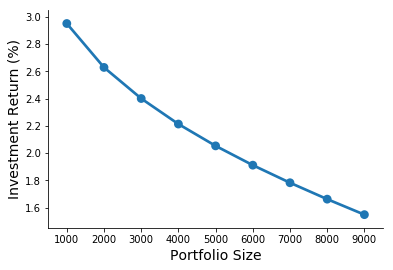

In [51]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, classifier=random_forest_afterRemoving, regressor=reg_rf_separate, strategy=test_strategy, num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()